In [1]:
%cd /Users/rodrigo/Post-Grad/CC400/Repo

/Users/rodrigo/Post-Grad/CC400/Repo


In [2]:
from utils import import_data, compute_KNN_graph, create_graph, create_batch,reconstruct_symmetric_matrix
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch_geometric
import torch.nn as nn
from torch_geometric.data import Data
from torch_geometric.utils import dense_to_sparse
from sklearn.model_selection import cross_validate
from tqdm import tqdm
from torch_geometric.loader import DataLoader
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_absolute_error,mean_squared_error


%matplotlib inline
sns.set(rc={'image.cmap': 'coolwarm'})

#from numba import jit,prange

import time
import os

SMALL_SIZE = 8
MEDIUM_SIZE = 14
BIGGER_SIZE = 20

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

scoring = {'acc': 'accuracy',
           'prec_macro': 'precision_macro',
           'rec_macro': 'recall_macro',
          'f1' : 'f1_macro',
          'roc_auc' : 'roc_auc'} 

In [3]:
print(torch.__version__)

1.13.1


In [4]:
print(torch_geometric.__version__)

2.1.0


In [5]:
df, phenotypic = import_data(fisher=True)
df = df.join(pd.DataFrame(phenotypic.Age), how='left')
df = df.join(pd.DataFrame(phenotypic['ADHD Measure']), how='left')

df = ((df.reset_index()).drop(columns=['Institution', 'Subject'])).dropna(subset=[str(x) for x in range(0,17955)])
df = df.dropna(axis=0, subset=['Age'])

from sklearn.utils import shuffle
df = shuffle(df, random_state=42)

# Real test set
TEST =  df.iloc[-30:]

df = df.iloc[:-30]

# Labels
y = (df.Age).apply(lambda x: int(x))

# Remove from Fisher-space
X = np.tanh(df.iloc[:,:-2])
X_TEST =  np.tanh(TEST.iloc[:,:-2])
y_TEST =  (TEST.Age).apply(lambda x: int(x))

In [6]:
from sklearn.model_selection import train_test_split

# Split train and validation set
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.15, shuffle=True, random_state=42)

In [15]:
A = reconstruct_symmetric_matrix(190,X_train.iloc[150])


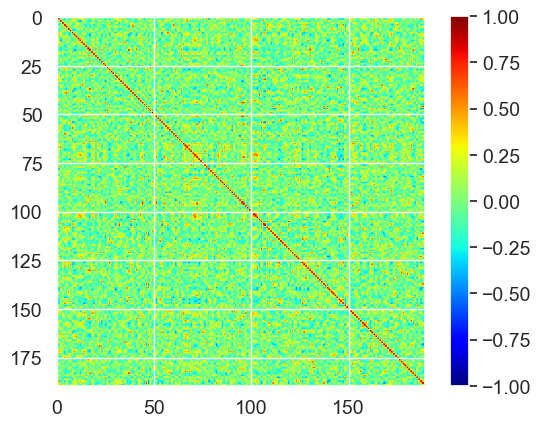

In [22]:
plt.imshow(A, cmap='jet',vmin=-1,vmax=1)
plt.colorbar()
plt.show()

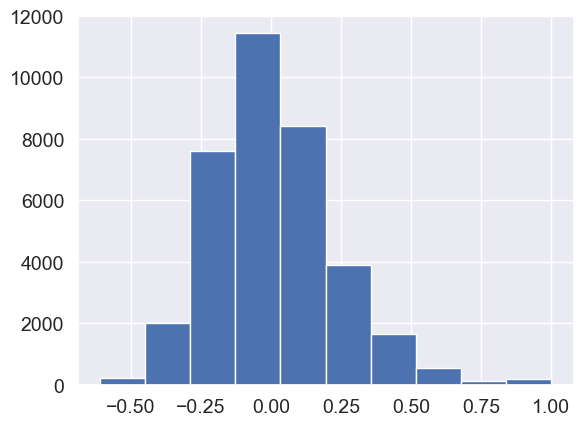

In [21]:
plt.hist(A.ravel())
plt.show()

## K-NN for selecting edges

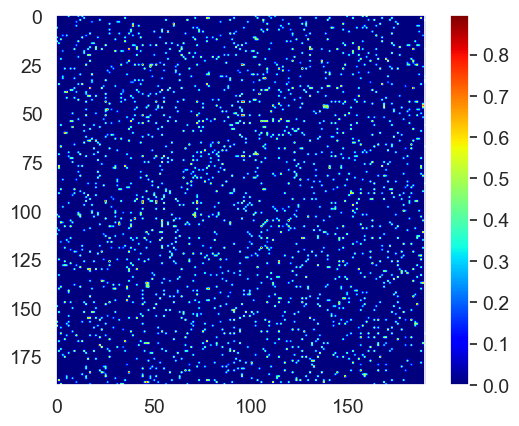

In [17]:
plt.imshow(np.array(compute_KNN_graph(A, 10)),cmap='jet')
plt.colorbar()
plt.grid(False)
plt.show()

## Creating the graphs

In [10]:
train_data, val_data = create_graph(X_train, X_test, y_train, y_test) #,method={'threshold': 0.2})

train_data, TEST_data = create_graph(X_train, X_TEST, y_train, y_TEST) #,method={'threshold': 0.2})

In [11]:
print(train_data[0])

Data(x=[190, 190], edge_index=[2, 2546], edge_attr=[2546, 1], y=11)


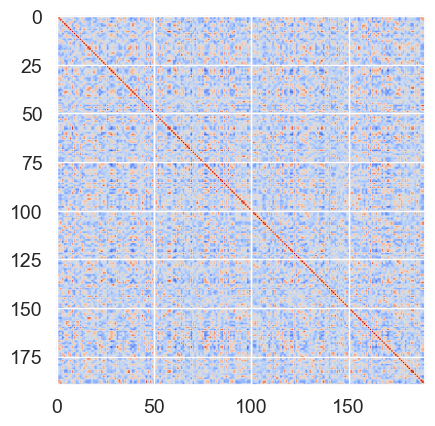

In [12]:
plt.imshow(train_data[-1].x)

In [13]:
train_loader, val_loader = create_batch(train_data, val_data, batch_size=32)

TRAIN_loader, TEST_loader = create_batch(train_data, TEST_data, batch_size=32)

In [48]:
import torch
import torch.nn.functional as func
from torch_geometric.nn import ChebConv, GCNConv, global_mean_pool, GATv2Conv, global_max_pool
from torch_geometric.nn import aggr


class GCN(torch.nn.Module):
    """GCN model(network architecture can be modified)"""

    def __init__(self,
                 num_features,
                 num_classes,
                 k_order,
                 dropout=.3):
        super(GCN, self).__init__()

        self.p = dropout
        
        #self.conv1 = GCNConv(int(num_features), 148)
        #self.conv2 = GCNConv(148,100)
        #self.conv3 = GCNConv(100,64)
        
        #self.gat1 = GATv2Conv(int(num_features), 148, heads=4, edge_dim=1)
        #self.gat2 = GATv2Conv(148*6, 100, heads=1)
        #self.gat3 = GATv2Conv(100*2, 64, heads=1)
        
        self.conv1 = ChebConv(int(num_features), 148, K=k_order)
        self.conv2 = ChebConv(148, 100, K=k_order)
        self.conv3 = ChebConv(100, 64, K=k_order)

        self.lin1 = torch.nn.Linear(64, 4)
        self.lin2 = torch.nn.Linear(4, 1)
        
        #torch.nn.init.xavier_normal_(self.gat1)
        #torch.nn.init.xavier_normal_(self.gat2)
        torch.nn.init.xavier_normal_(self.lin1.weight)


        
        self.bn1 = torch.nn.BatchNorm1d(148) #148*6
        self.bn2 = torch.nn.BatchNorm1d(100)
        self.bn3 = torch.nn.BatchNorm1d(64)
        
        self.pool = global_mean_pool
        
        self.aggregation = aggr.SoftmaxAggregation()

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        batch = data.batch

        x = func.relu(self.conv1(x, edge_index, edge_attr))  #WHY NAN WITH EDGE_ATTR (non-negative)
        #x = self.gat1(x=x, edge_index = edge_index, edge_attr=edge_attr) #func.elu(self.gat1(x=x, edge_index = edge_index, edge_attr=edge_attr))
        x = func.dropout(x, p=self.p, training=self.training)
        x = self.bn1(x)
        x = func.relu(self.conv2(x, edge_index, edge_attr))  #WHY NAN WITH EDGE_ATTR (non-negative)
        #x = func.elu(self.gat2(x, edge_index))
        x = func.dropout(x, p=self.p, training=self.training)
        x = self.bn2(x)
        x = func.relu(self.conv3(x, edge_index,edge_attr))  #, edge_attr, batch))  #WHY NAN WITH EDGE_ATTR (non-negative)
        #x = func.elu(self.gat3(x, edge_index))
        #x = func.dropout(x, p=self.p, training=self.training)
        x = self.bn3(x)
        
        x = self.pool(x, batch)
        #x = self.aggregation(x, batch)
        x = self.lin1(x)
        #x = func.dropout(x, p=self.p, training=self.training)
        x = self.lin2(x)
        #x = func.dropout(x, p=self.p, training=self.training)
        #print(x.shape)
        return x

In [49]:
def init_weights(m):
    if isinstance(m, GATv2Conv):
        m.reset_parameters()
        if m.bias is not None: 
            nn.init.zeros_(m.bias)
    if isinstance(m, nn.Linear):
        m.reset_parameters()
        #nn.init.normal_(m.weight, mean=0.0, std=np.sqrt(1 / m.in_features))
        if m.bias is not None: 
            nn.init.zeros_(m.bias)


# Testing in one fold

In [63]:
def TRAIN_LOSS(loader):
    model.eval()
    l1_weight = 0
    loss = nn.MSELoss()
    
    pred = []
    label = []
    
    loss_all = 0
    for data in loader:
        data = data.to(device)
        output = model(data)
        l1_penalty = l1_weight * sum([p.abs().sum() for p in model.parameters()])
        loss_value = loss(output.squeeze(), (data.y).float())
        loss_with_penalty = loss_value + l1_penalty
        loss_all += data.num_graphs * loss_with_penalty.item()
        pred.append(output)
        label.append(data.y)

    y_pred = torch.cat(pred, dim=0).cpu().detach().numpy()
    y_true = torch.cat(label, dim=0).cpu().detach().numpy()
    mae = mean_absolute_error(y_pred,y_true)
    mse = mean_squared_error(y_pred, y_true)

    return mae, mse, loss_all / len(train_data)

def GCN_train(loader, loop):
    model.train()
    loss = nn.MSELoss()
    l1_weight = 0
    loss_all = 0
    pred = []
    label = []
    
        
    for (x, y) in enumerate(loop):
        y = y.to(device)
        optimizer.zero_grad()
        output = model(y)
        # Adding L1 regularization
        l1_penalty = l1_weight * sum([p.abs().sum() for p in model.parameters()])
        loss_value = loss(output.squeeze(), (y.y).float())
        loss_with_penalty = loss_value + l1_penalty
        loss_with_penalty.backward()
        optimizer.step()
        loss_all += y.num_graphs * loss_with_penalty.item()
        pred.append(output)
        label.append(y.y)

        loop.set_description(f"Epoch [{epoch}/{NUM_EPOCHS}]")
        loop.set_postfix(loss=loss_all/len(train_data))
        #optimizer.step()
    y_pred = torch.cat(pred, dim=0).cpu().detach().numpy()
    y_true = torch.cat(label, dim=0).cpu().detach().numpy()
    mae = mean_absolute_error(y_pred,y_true)
    mse = mean_squared_error(y_pred, y_true)
    
        
    return mae, mse, loss_all / len(train_data)


def GCN_test(loader):
    
    model.eval()
    l1_weight = 0
    loss = nn.MSELoss()
    
    pred = []
    label = []
    
    loss_all = 0
    for data in loader:
        data = data.to(device)
        output = model(data)
        l1_penalty = l1_weight * sum([p.abs().sum() for p in model.parameters()])
        loss_value = loss(output.squeeze(), (data.y).float())
        loss_with_penalty = loss_value + l1_penalty
        loss_all += data.num_graphs * loss_with_penalty.item()
        pred.append(output)
        label.append(data.y)

    y_pred = torch.cat(pred, dim=0).cpu().detach().numpy()
    y_true = torch.cat(label, dim=0).cpu().detach().numpy()
    mae = mean_absolute_error(y_pred,y_true)
    mse = mean_squared_error(y_pred, y_true)
    
    return mae,mse, loss_all / len(val_data)


In [64]:
metrics = {"loss_train" : [], "loss_test" : [], "mae_test" : [], "mae_train" : []}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(190, 2, 3).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, weight_decay=1e-3)#,momentum=0.35)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10], gamma=.1, verbose=True)

for layer in model.children():
    if hasattr(layer, 'reset_parameters'):
        layer.reset_parameters()
   
model.apply(init_weights)

min_v_loss = np.inf  

NUM_EPOCHS = 100

for epoch in range(1,NUM_EPOCHS + 1):
    loop = tqdm(train_loader)
    train_mae, train_mse, train_loss = GCN_train(train_loader,loop)
    test_mae, test_mse, test_loss = GCN_test(val_loader)
    TRAIN_mae, TRAIN_mse, TRAIN_loss = TRAIN_LOSS(train_loader)
    
    #scheduler.step()
    
    metrics['loss_train'].append(TRAIN_loss)
    metrics['loss_test'].append(test_loss)
    metrics['mae_test'].append(test_mae)
    metrics['mae_train'].append(TRAIN_mae)
    
    print('Val MAE {} , Val Loss {}'.format(test_mae, test_loss))
    print('Train MAE {} , Train Loss {}'.format(TRAIN_mae, TRAIN_loss))

#     y_pred = {'x1' : [], 'x2' : [], 'label' : []}
#     for y in val_loader:
#         y_pred['x1'].append(model(y).detach().numpy()[0][0])
#         y_pred['x2'].append(model(y).detach().numpy()[0][1])
#         y_pred['label'].append(y.y.detach().numpy()[0])
        
#     sns.scatterplot(data=pd.DataFrame.from_dict(y_pred) , x='x1', y='x2', hue='label')
#     plt.show()
    

Adjusting learning rate of group 0 to 1.0000e-03.


Epoch [1/100]:  45%|████████          | 9/20 [00:02<00:03,  3.58it/s, loss=61.8]


KeyboardInterrupt: 


### Debug

In [26]:
model.eval()

GCN(
  (conv1): ChebConv(190, 148, K=3, normalization=sym)
  (conv2): ChebConv(148, 100, K=3, normalization=sym)
  (lin1): Linear(in_features=100, out_features=4, bias=True)
  (lin2): Linear(in_features=4, out_features=1, bias=True)
  (bn1): BatchNorm1d(148, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (aggregation): SoftmaxAggregation(learn=False)
)

In [27]:
y_pred = []
for y_i in TEST_loader:
    y_pred.append((model(y_i)).detach().numpy()[0])
    
print('TEST mae', mean_absolute_error(y_TEST.values.reshape(-1,1), y_pred))


TEST mae 2.667686907450358


In [28]:
y_pred = []
for y_i in val_loader:
    y_pred.append((model(y_i)).detach().numpy()[0])


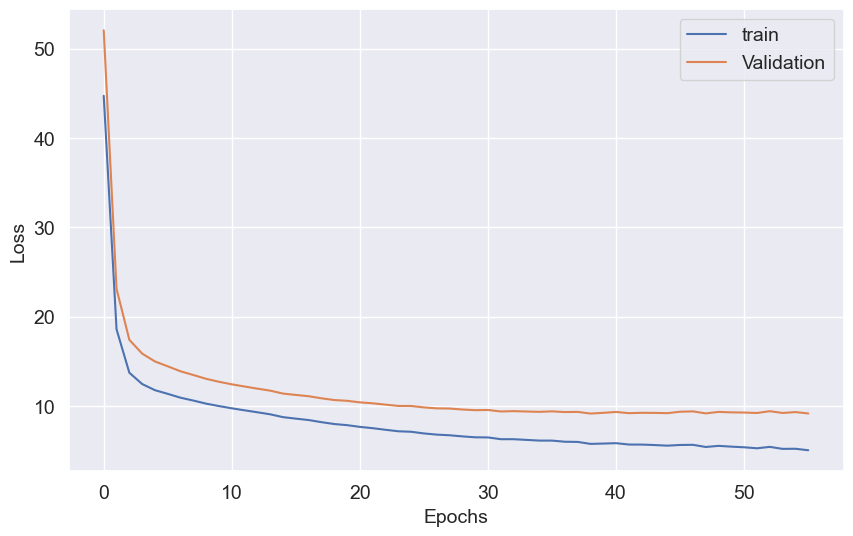

In [29]:
fig,ax = plt.subplots(figsize=(10,6))
ax.plot(metrics['loss_train'], label='train')
ax.plot(metrics['loss_test'], label='Validation')
ax.set_ylabel('Loss')
ax.set_xlabel('Epochs')
#plt.xlim(80,100)
ax.legend()
plt.show()

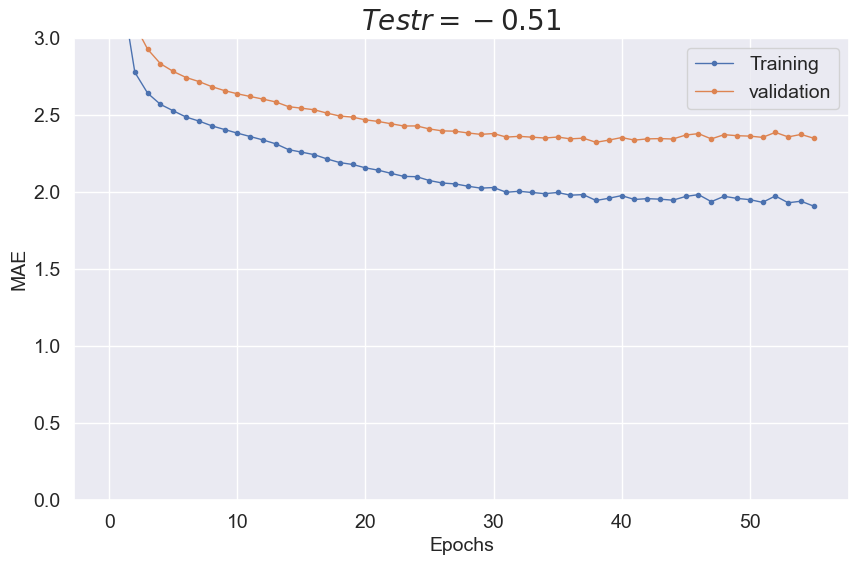

In [30]:
fig,ax = plt.subplots(figsize=(10,6))
ax.plot(metrics['mae_train'], label='Training', linewidth=1,marker='.')
ax.plot(metrics['mae_test'], label='validation', linewidth=1,marker='.')
ax.set_ylabel('MAE')
ax.set_xlabel('Epochs')
ax.set_title(r'$Test r = {:.2f}$'.format(np.corrcoef(np.arange(0,len(metrics['mae_test'])), metrics['mae_test'])[0][1]))
ax.legend()
plt.ylim(0,3)
plt.show()

## Kfold Cross validation

In [176]:
inputs = X
targets = y

eval_scores = {"loss_train" : [], "loss_test" : [], "mae_test" : [], "mae_train" : []}

scores = np.zeros((3,10))
# Define the K-fold Cross Validator
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(inputs, targets):
    
    # creating the graphs
    train_data, val_data = create_graph(X.iloc[train], X.iloc[test],
                                         y.iloc[train], y.iloc[test])
    
    # creating the batchs inside the torch DataLoader
    train_loader, val_loader = create_batch(train_data, val_data, batch_size=32)
    

    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    
    # Train the NN Archithecture
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = GCN(190, 2, 3).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-3)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10], gamma=0.1, verbose=True)

    
    model.apply(init_weights)

    for layer in model.children():
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()

    min_v_loss = np.inf  

    NUM_EPOCHS = 40
    for epoch in range(1,NUM_EPOCHS + 1):
        loop = tqdm(train_loader)
        train_mae, train_mse, train_loss = GCN_train(train_loader,loop)
        test_mae, test_mse, test_loss = GCN_test(val_loader)
        
        #scheduler.step()
    

        eval_scores['loss_train'].append(train_loss)
        eval_scores['loss_test'].append(test_loss)
        eval_scores['mae_test'].append(test_mae)
        eval_scores['mae_train'].append(train_mae)

    
    scores[0][fold_no - 1] = test_mae
    scores[1][fold_no - 1] = test_loss
    scores[2][fold_no - 1] = test_mse

    print(f'Score for fold {fold_no}: loss of {test_loss}; mae of {test_mae}%')

    # Increase fold number
    fold_no = fold_no + 1

/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=10.
  warnings.warn(


------------------------------------------------------------------------
Training for fold 1 ...
Adjusting learning rate of group 0 to 1.0000e-03.


Epoch [1/40]: 100%|███████████████████| 21/21 [00:03<00:00,  5.63it/s, loss=137]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch [2/40]: 100%|███████████████████| 21/21 [00:03<00:00,  5.71it/s, loss=128]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch [3/40]: 100%|███████████████████| 21/21 [00:04<00:00,  4.26it/s, loss=11

Score for fold 1: loss of 5.378801679300473; mae of 1.7742637412188804%
------------------------------------------------------------------------
Training for fold 2 ...
Adjusting learning rate of group 0 to 1.0000e-03.


Epoch [1/40]: 100%|███████████████████| 21/21 [00:04<00:00,  4.96it/s, loss=144]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch [2/40]: 100%|███████████████████| 21/21 [00:04<00:00,  4.94it/s, loss=136]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch [3/40]: 100%|███████████████████| 21/21 [00:04<00:00,  4.82it/s, loss=12

Score for fold 2: loss of 3.858753587594511; mae of 1.5460470604569945%
------------------------------------------------------------------------
Training for fold 3 ...
Adjusting learning rate of group 0 to 1.0000e-03.


Epoch [1/40]: 100%|███████████████████| 21/21 [00:04<00:00,  4.71it/s, loss=150]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch [2/40]: 100%|███████████████████| 21/21 [00:04<00:00,  4.84it/s, loss=142]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch [3/40]: 100%|███████████████████| 21/21 [00:04<00:00,  4.71it/s, loss=12

Score for fold 3: loss of 4.75249810055399; mae of 1.793851721776675%
------------------------------------------------------------------------
Training for fold 4 ...
Adjusting learning rate of group 0 to 1.0000e-03.


Epoch [1/40]: 100%|███████████████████| 21/21 [00:04<00:00,  5.04it/s, loss=140]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch [2/40]: 100%|███████████████████| 21/21 [00:04<00:00,  4.85it/s, loss=133]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch [3/40]: 100%|███████████████████| 21/21 [00:04<00:00,  4.80it/s, loss=12

Score for fold 4: loss of 3.4141649444306856; mae of 1.4967739876002482%
------------------------------------------------------------------------
Training for fold 5 ...
Adjusting learning rate of group 0 to 1.0000e-03.


Epoch [1/40]: 100%|███████████████████| 21/21 [00:04<00:00,  5.05it/s, loss=146]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch [2/40]: 100%|███████████████████| 21/21 [00:04<00:00,  4.89it/s, loss=139]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch [3/40]: 100%|███████████████████| 21/21 [00:04<00:00,  4.83it/s, loss=12

Score for fold 5: loss of 8.349960963020886; mae of 2.189152188497047%
------------------------------------------------------------------------
Training for fold 6 ...
Adjusting learning rate of group 0 to 1.0000e-03.


Epoch [1/40]: 100%|███████████████████| 21/21 [00:04<00:00,  5.00it/s, loss=131]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch [2/40]: 100%|███████████████████| 21/21 [00:04<00:00,  4.98it/s, loss=125]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch [3/40]: 100%|███████████████████| 21/21 [00:04<00:00,  4.88it/s, loss=11

Score for fold 6: loss of 5.450031695801331; mae of 1.8919661077734542%
------------------------------------------------------------------------
Training for fold 7 ...
Adjusting learning rate of group 0 to 1.0000e-03.


Epoch [1/40]: 100%|███████████████████| 21/21 [00:04<00:00,  5.15it/s, loss=145]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch [2/40]: 100%|███████████████████| 21/21 [00:04<00:00,  5.08it/s, loss=138]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch [3/40]: 100%|███████████████████| 21/21 [00:04<00:00,  4.97it/s, loss=12

Score for fold 7: loss of 3.6591626561313793; mae of 1.4703445238609836%
------------------------------------------------------------------------
Training for fold 8 ...
Adjusting learning rate of group 0 to 1.0000e-03.


Epoch [1/40]: 100%|███████████████████| 21/21 [00:04<00:00,  4.57it/s, loss=150]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch [2/40]: 100%|███████████████████| 21/21 [00:04<00:00,  4.93it/s, loss=145]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch [3/40]: 100%|███████████████████| 21/21 [00:04<00:00,  4.96it/s, loss=13

Score for fold 8: loss of 4.2054459441015855; mae of 1.5453460481431749%
------------------------------------------------------------------------
Training for fold 9 ...
Adjusting learning rate of group 0 to 1.0000e-03.


Epoch [1/40]: 100%|███████████████████| 21/21 [00:04<00:00,  4.96it/s, loss=148]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch [2/40]: 100%|███████████████████| 21/21 [00:04<00:00,  4.91it/s, loss=143]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch [3/40]: 100%|███████████████████| 21/21 [00:04<00:00,  4.85it/s, loss=13

Score for fold 9: loss of 6.557114792392692; mae of 1.9116750558217366%
------------------------------------------------------------------------
Training for fold 10 ...
Adjusting learning rate of group 0 to 1.0000e-03.


Epoch [1/40]: 100%|███████████████████| 21/21 [00:04<00:00,  4.44it/s, loss=151]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch [2/40]: 100%|███████████████████| 21/21 [00:04<00:00,  4.87it/s, loss=146]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch [3/40]: 100%|███████████████████| 21/21 [00:04<00:00,  4.86it/s, loss=13

Score for fold 10: loss of 5.276907374744648; mae of 1.7503396934933133%


In [123]:
print('Average MAE in CV: {:.2f}({:.2f}) \n'.format(scores[0].mean(), scores[0].std()))
print('Average Loss in CV: {:.2f}({:.2f}) \n'.format(scores[1].mean(), scores[1].std()))

Average MAE in CV: 1.70(0.19) 

Average Loss in CV: 4.82(1.05) 



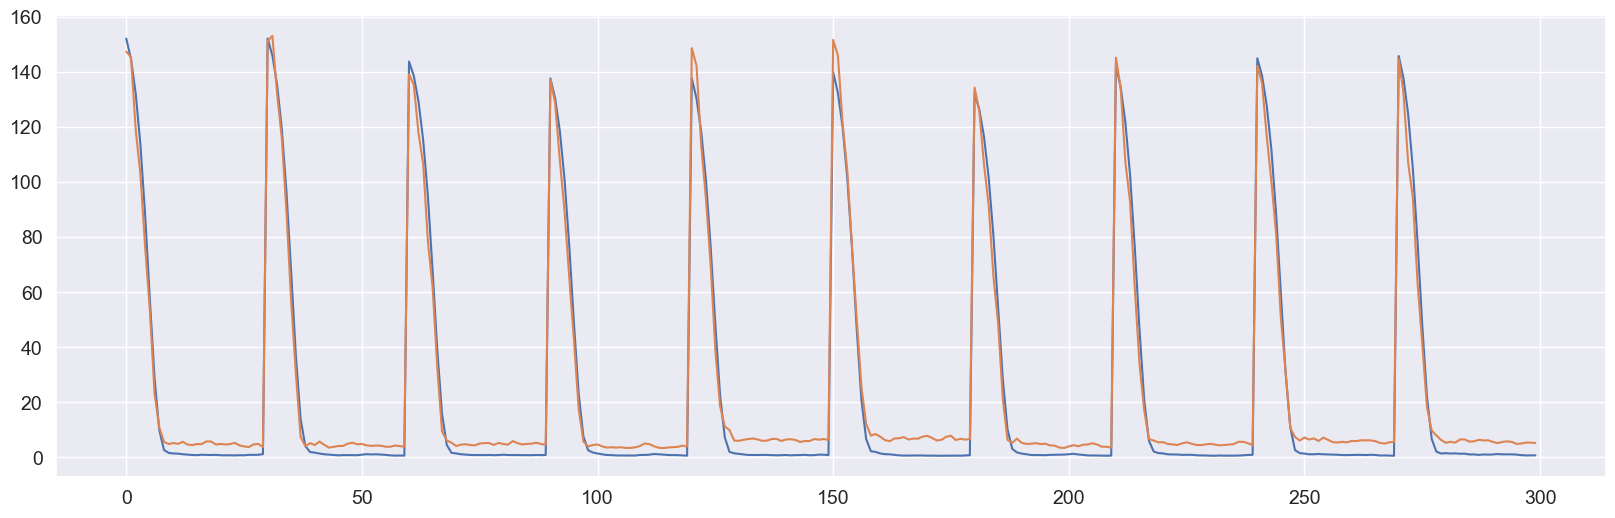

In [124]:
plt.figure(figsize=(20,6))
plt.plot(eval_scores['loss_train'])
plt.plot(eval_scores['loss_test'])

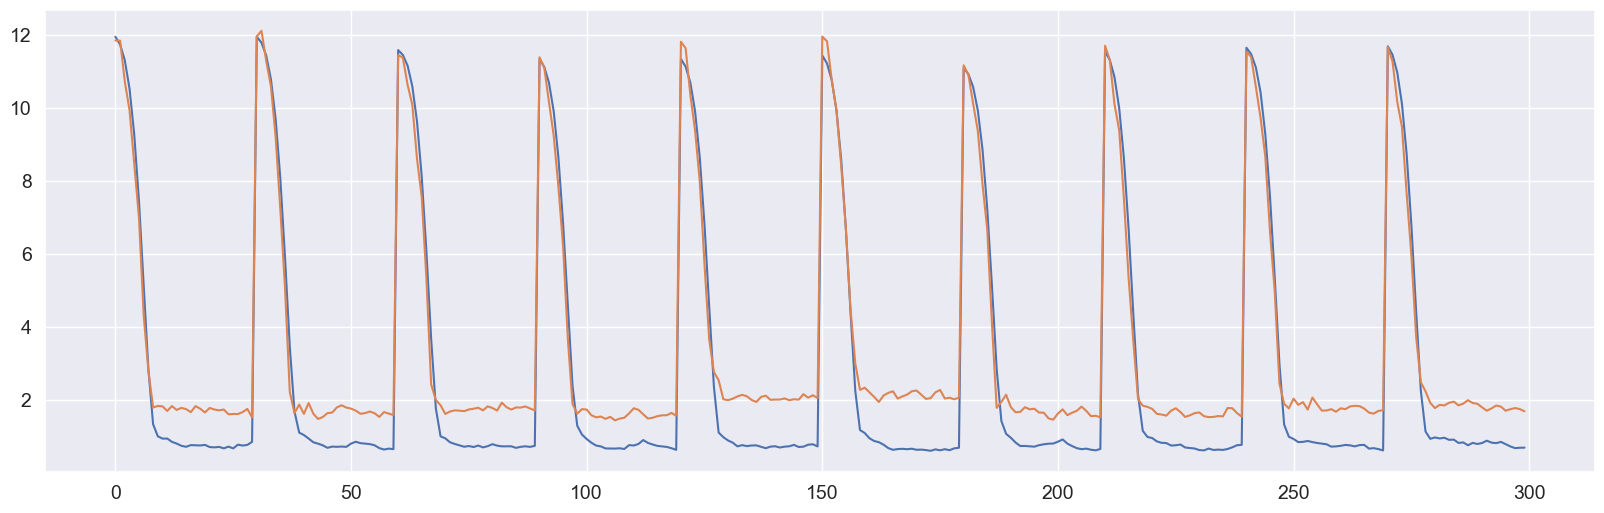

In [125]:
plt.figure(figsize=(20,6))
plt.plot(eval_scores['mae_train'])
plt.plot(eval_scores['mae_test'])

In [127]:
pd.DataFrame(scores.T, columns=['test_mae', 'test_loss', 'test_mse']).to_csv('/Users/rodrigo/Post-Grad/CC400/Results/GCN_age_mse_2.csv')